In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
from random import randint
from copy import deepcopy
import pickle as pkl
import argparse

from torch import nn
from models import AutoEncoder, AutoEncoderSimple, load_model
import torch.nn.functional as F

from models import load_model
sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from model import init_specific_model
from losses import get_loss_f, _reconstruction_loss
from training import Trainer
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder, TrimModel
from captum.attr import *

# wavelet
from pytorch_wavelets import DTCWTForward, DTCWTInverse
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
from kymatio.torch import Scattering2D
from kymatio.scattering2d.filter_bank import filter_bank
from kymatio.scattering2d.utils import fft2
from colorsys import hls_to_rgb

In [2]:
def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0/(1.0 + abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
    return c

In [ ]:
M = 256
J = 3
L = 8
batch_size = 64
filters_set = filter_bank(M, M, J, L=L)

In [ ]:
# bandpass filters
fig, axs = plt.subplots(J, L, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(6)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
i = 0
for filter in filters_set['psi']:
    f = filter[0]
    filter_c = fft2(f)
    filter_c = np.fft.fftshift(filter_c)
    axs[i // L, i % L].imshow(colorize(filter_c))
    axs[i // L, i % L].axis('off')
    axs[i // L, i % L].set_title(
        "$j = {}$ \n $\\theta={}$".format(i // L, i % L))
    i = i+1

fig.suptitle((r"Wavelets for each scales $j$ and angles $\theta$ used."
              "\nColor saturation and color hue respectively denote complex "
              "magnitude and complex phase."), fontsize=13)
fig.show()

In [ ]:
plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.axis('off')
plt.set_cmap('gray_r')

f = filters_set['phi'][0]

filter_c = fft2(f)
filter_c = np.fft.fftshift(filter_c)
plt.suptitle(("The corresponding low-pass filter, also known as scaling "
              "function.\nColor saturation and color hue respectively denote "
              "complex magnitude and complex phase"), fontsize=13)
filter_c = np.abs(filter_c)
plt.imshow(filter_c)

plt.show()

# Decode Scattering Transform

In [40]:
class Generator(nn.Module):
    def __init__(self, num_input_channels, num_hidden_channels, num_output_channels=1, filter_size=3):
        super(Generator, self).__init__()
        self.num_input_channels = num_input_channels
        self.num_hidden_channels = num_hidden_channels
        self.num_output_channels = num_output_channels
        self.filter_size = filter_size
        self.build()

    def build(self):
        padding = (self.filter_size - 1) // 2

        self.main = nn.Sequential(
            nn.ReflectionPad2d(padding),
            nn.Conv2d(self.num_input_channels, self.num_hidden_channels, self.filter_size, bias=False),
            nn.BatchNorm2d(self.num_hidden_channels, eps=0.001, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            nn.ReflectionPad2d(padding),
            nn.Conv2d(self.num_hidden_channels, self.num_hidden_channels, self.filter_size, bias=False),
            nn.BatchNorm2d(self.num_hidden_channels, eps=0.001, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            nn.ReflectionPad2d(padding),
            nn.Conv2d(self.num_hidden_channels, self.num_hidden_channels, self.filter_size, bias=False),
            nn.BatchNorm2d(self.num_hidden_channels, eps=0.001, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),            

            nn.ReflectionPad2d(padding),
            nn.Conv2d(self.num_hidden_channels, self.num_output_channels, self.filter_size, bias=False),
            nn.BatchNorm2d(self.num_output_channels, eps=0.001, momentum=0.9),
            nn.Tanh()
        )

    def forward(self, input_tensor):
        return self.main(input_tensor)

In [41]:
# create dir
out_dir = opj(p.out_dir, p.dirname)
os.makedirs(out_dir, exist_ok=True)  

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# get dataloaders
train_loader = get_dataloader(p.data_path, 
                              img_size=256,
                              batch_size=p.train_batch_size)
im = iter(train_loader).next()[0][0:1].to(device)

# load model
model = load_model(model_name='resnet18', device=device, data_path=p.data_path)
model = model.eval()
# freeze layers
for param in model.parameters():
    param.requires_grad = False

In [45]:
# scatter transform
M = 256
J = 3
L = 8
scattering = Scattering2D(J, shape=(M, M), L=L, max_order=1).to(device)
shape = scattering(im).shape[2:]

num_input_channels = shape[0]
num_hidden_channels = num_input_channels

In [51]:
generator = Generator(num_input_channels, num_hidden_channels).to(device)
generator.train()

criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(generator.parameters())

# Training Loop
# Lists to keep track of progress
losses = []
num_epochs = 10

for epoch in range(num_epochs):
    print('Training epoch {}\n'.format(epoch))
    epoch_loss = 0
    for batch_idx, (current_batch, _) in enumerate(train_loader):
        generator.zero_grad()
        batch_images = current_batch.to(device)
        batch_scattering = scattering(batch_images).squeeze(1)
        batch_inverse_scattering = generator(batch_scattering)
        loss = criterion(batch_inverse_scattering, batch_images)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data.item()
        
        # Output training stats
        if batch_idx % 50 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(current_batch), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data.item()), end='')        

    # Save Losses for plotting later
    losses.append(epoch_loss/(batch_idx + 1))

Training epoch 0
Train Epoch: 0 [28800/30000 (96%)]	Loss: 0.015313Training epoch 1
Train Epoch: 1 [28800/30000 (96%)]	Loss: 0.013395Training epoch 2
Train Epoch: 2 [28800/30000 (96%)]	Loss: 0.011365Training epoch 3
Train Epoch: 3 [28800/30000 (96%)]	Loss: 0.009902Training epoch 4
Train Epoch: 4 [28800/30000 (96%)]	Loss: 0.009017Training epoch 5
Train Epoch: 5 [28800/30000 (96%)]	Loss: 0.011537Training epoch 6
Train Epoch: 6 [28800/30000 (96%)]	Loss: 0.009459Training epoch 7
Train Epoch: 7 [28800/30000 (96%)]	Loss: 0.009383Training epoch 8
Train Epoch: 8 [28800/30000 (96%)]	Loss: 0.009762Training epoch 9
Train Epoch: 9 [28800/30000 (96%)]	Loss: 0.008545

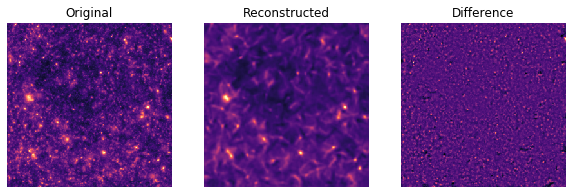

In [56]:
generator = Generator(num_input_channels, num_hidden_channels).to(device)
generator.load_state_dict(torch.load('results/inverse_scatter_transform.pth'))
im = iter(train_loader).next()[0].to(device)
recon_data = generator(scattering(im).squeeze(1))
viz_im_r(im[0,0], recon_data[0,0])

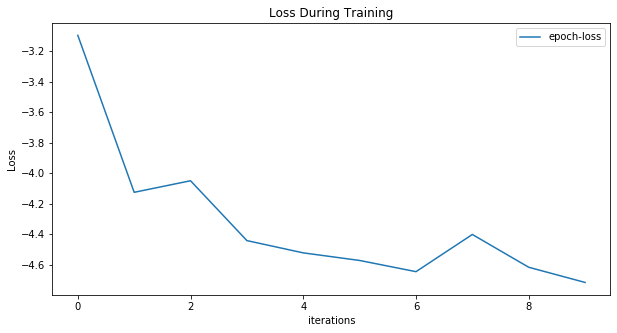

In [55]:
# loss versus training iterations
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(np.log(losses), label="epoch-loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()